In [6]:
import math
import numpy as np
import scipy as sp
from scipy.linalg import eig
from numpy import sin, cos, abs, exp, sqrt, arccos, pi, conj, argmin, real, imag

%matplotlib inline
import matplotlib.pyplot as plt
%config InlineBackend.figure_format ="retina"
import matplotlib as mpl
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
import time

In [7]:
gamma = 5e-2 # Loss rate
J = 1.0 # Tunneling
N = 500 # Number of cavities

U = 0.5 # Kerr non-linearity
Delta_list = np.linspace(0.01, 2.0, 50) # Detuning
F_list = np.sqrt(Delta_list*J**2/U) # Pump

# Momenta
k = np.arange(-pi, (pi+2*pi/N), 2*pi/N)
n = np.linspace(0, N-1, N)

kn = np.einsum('k,n->kn', k, n)
E_kn = np.exp(-1.0j*kn)

len(k) = 501


In [8]:
N_t = 1e4 # 1e4 # Number of time steps
t_f = 1e3 # Final time
t = np.linspace(0, t_f, int(N_t))
Delta_t = t[1] - t[0]

In [9]:
def f_RK4(Delta, U, a_k, F_k):

    a_k_m = np.insert(a_k[:-1], 0, 0)
    a_k_p = np.append(a_k[1:], 0)

    y = -1.0j * (
        -(Delta + 2*J*cos(k))*a_k + U/N*abs(a_k)**2*a_k + 2*U/N*abs(a_k_p)**2*a_k + 2*U/N*abs(a_k_m)**2*a_k + 2*U/N*conj(a_k)*a_k_p*a_k_m - 1.0j*gamma*a_k + F_k
    )
    
    return y

def BogoEig(Delta, U, a_k):
    '''
    Diagonalizes Bogoliubov matrix and returns eigenvalues.
    '''
    
    A = np.zeros((2*len(k), 2*len(k)), dtype=np.complex128)

    A[0, 0] = - (Delta + 2*J*cos(k[0])) + 2*U/N*abs(a_k[0])**2 + 2*U/N*abs(a_k[1])**2 - 1.0j*gamma
    A[0, 1] = U/N*a_k[0]**2
    A[0, 2] = 2*U/N*conj(a_k[1])*a_k[0]
    A[0, 3] = 2*U/N*a_k[1]*a_k[0]

    A[1, 0] = - U/N*conj(a_k[0])**2
    A[1, 1] = (Delta + 2*J*cos(k[0])) - 2*U/N*abs(a_k[0])**2 - 2*U/N*abs(a_k[1])**2 - 1.0j*gamma
    A[1, 2] = - 2*U/N*conj(a_k[1])*conj(a_k[0])
    A[1, 3] = - 2*U/N*a_k[1]*conj(a_k[0])

    for i in range(1, len(k)-1):

        A[2*i, 2*i-2] = 2*U/N*conj(a_k[i-1])*a_k[i] + 2*U/N*conj(a_k[i])*a_k[i+1]
        A[2*i, 2*i-1] = 2*U/N*a_k[i-1]*a_k[i]
        A[2*i, 2*i] = - (Delta + 2*J*cos(k[i])) + 2*U/N*abs(a_k[i])**2 + 2*U/N*abs(a_k[i+1])**2 + 2*U/N*abs(a_k[i-1])**2 - 1.0j*gamma
        A[2*i, 2*i+1] = U/N*a_k[i]**2 + 2*U/N*a_k[i+1]*a_k[i-1]
        A[2*i, 2*i+2] = 2*U/N*conj(a_k[i+1])*a_k[i] + 2*U/N*conj(a_k[i])*a_k[i-1]
        A[2*i, 2*i+3] = 2*U/N*a_k[i+1]*a_k[i]

        A[2*i+1, 2*i-2] = - 2*U/N*conj(a_k[i-1])*conj(a_k[i])
        A[2*i+1, 2*i-1] = - 2*U/N*a_k[i-1]*conj(a_k[i]) - 2*U/N*a_k[i]*conj(a_k[i+1])
        A[2*i+1, 2*i] = - U/N*conj(a_k[i])**2 - 2*U/N*conj(a_k[i+1])*conj(a_k[i-1])
        A[2*i+1, 2*i+1] = (Delta + 2*J*cos(k[i])) - 2*U/N*abs(a_k[i])**2 - 2*U/N*abs(a_k[i+1])**2 - 2*U/N*abs(a_k[i-1])**2 - 1.0j*gamma
        A[2*i+1, 2*i+2] = - 2*U/N*conj(a_k[i+1])*conj(a_k[i])
        A[2*i+1, 2*i+3] = - 2*U/N*a_k[i+1]*conj(a_k[i]) - 2*U/N*a_k[i]*conj(a_k[i-1])

    i = len(k)-1

    A[2*i, 2*i-2] = 2*U/N*conj(a_k[i-1])*a_k[i]
    A[2*i, 2*i-1] = 2*U/N*a_k[i-1]*a_k[i]
    A[2*i, 2*i] = - (Delta + 2*J*cos(k[i])) + 2*U/N*abs(a_k[i])**2 + 2*U/N*abs(a_k[i-1])**2 - 1.0j*gamma
    A[2*i, 2*i+1] = U/N*a_k[i]**2

    A[2*i+1, 2*i-2] = - 2*U/N*conj(a_k[i-1])*conj(a_k[i])
    A[2*i+1, 2*i-1] = - 2*U/N*a_k[i-1]*conj(a_k[i])
    A[2*i+1, 2*i] = - U/N*conj(a_k[i])**2
    A[2*i+1, 2*i+1] = (Delta + 2*J*cos(k[i])) - 2*U/N*abs(a_k[i])**2 - 2*U/N*abs(a_k[i-1])**2 - 1.0j*gamma

    w, V = eig(A)
    
    return w

In [10]:
a_k_conv = []
w_list = []

count = 0

# Cavity fields
a_k = np.zeros((int(N_t), len(k)), dtype=np.complex128)

# RK parameters
k1 = np.zeros(int(len(k)), dtype=np.complex128)
k2 = np.zeros(int(len(k)), dtype=np.complex128)
k3 = np.zeros(int(len(k)), dtype=np.complex128)
k4 = np.zeros(int(len(k)), dtype=np.complex128)

for F, Delta in zip(F_list, Delta_list):

    F_n = np.zeros(N, dtype=np.complex128)
    F_n[int(N/2-1)] = F
    F_n[int(N/2+1)] = F

    kn = np.einsum('k,n->kn', k, n)
    E_kn = np.exp(-1.0j*kn)
    F_k = np.einsum('kn,n->k', E_kn, F_n) / sqrt(N)

    for i_t in range(len(t)-1):

        k1 = f_RK4(Delta, U, a_k[i_t, :], F_k)
        k2 = f_RK4(Delta, U, a_k[i_t, :] + k1*Delta_t/2, F_k)
        k3 = f_RK4(Delta, U, a_k[i_t, :] + k2*Delta_t/2, F_k)
        k4 = f_RK4(Delta, U, a_k[i_t, :] + k3*Delta_t, F_k)

        a_k[i_t+1, :] = a_k[i_t, :] + (k1 + 2*k2 + 2*k3 + k4)*Delta_t/6
    
    a_k_conv.append(a_k[-1, :])
    a_k[0, :] = a_k[-1, :]

    w_list.append(BogoEig(Delta, U, a_k[-1, :]))

    count += 1

a_k_conv = np.array(a_k_conv)
w_list = np.array(w_list)

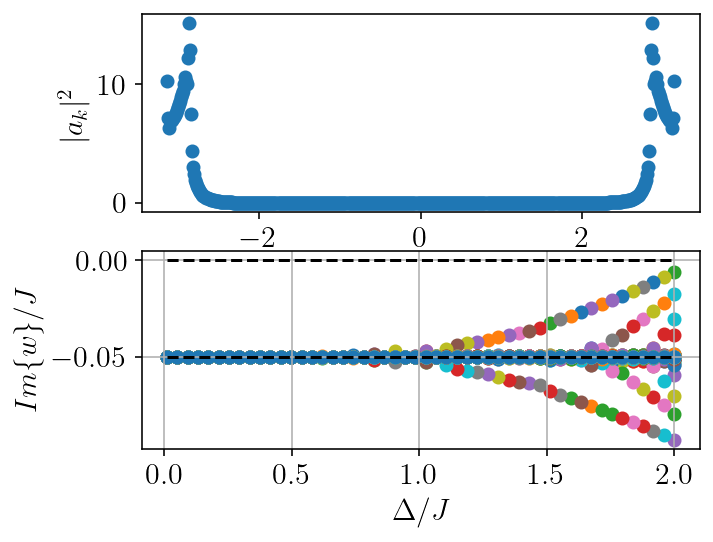

In [11]:
plt.rcParams["figure.figsize"] = [5, 4]
fig, ax = plt.subplots(2, 1)

index = 25

ax[1].grid()

ax[0].scatter(k, abs(a_k_conv[index, :])**2)
ax[0].set_xlabel(r'$k$',fontsize=15)
ax[0].set_ylabel(r'$|a_k|^2$',fontsize=15)
ax[0].tick_params(axis='both', labelsize=15)
ax[1].plot([min(Delta_list), max(Delta_list)], [0, 0], '--k')

w_array = np.array(w_list)
for i in range(len(k)):
    ax[1].scatter(Delta_list, np.imag(w_array[:, i]), color='blue')
ax[1].plot([min(Delta_list), max(Delta_list)], [-gamma, -gamma], '--k')
ax[1].set_xlabel(r'$\Delta/J$',fontsize=15)
ax[1].set_ylabel(r'$Im\{w\}/J$',fontsize=15)
ax[1].tick_params(axis='both', labelsize=15)